In [8]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pandas as pd
import pytensor
from scipy.linalg import cholesky

%matplotlib inline

In [9]:
cols = ['date','ticker','close','rsi','bb_low', 'bb_mid', 'bb_high', 'sharpe_ratio']
df = pd.read_csv("data/price_data.csv", usecols=cols)
df.head()

,date,ticker,close,rsi,bb_low,bb_mid,bb_high,sharpe_ratio
0,2017-01-03,A,43.559391,55.906011,3.757332,3.781197,3.805061,0.548844
1,2017-01-03,AAPL,26.827240,58.487161,3.274114,3.315296,3.356479,0.836831
2,2017-01-03,ABBV,43.078159,53.851836,3.756310,3.777267,3.798224,0.661857
3,2017-01-03,ABT,33.307190,50.624336,3.504776,3.523770,3.542764,0.568612
4,2017-01-03,ACGL,27.224224,59.555791,3.323679,3.345575,3.367472,0.645114


In [10]:
df = df.pivot(index="date", columns="ticker", values="close")

In [11]:
class Scaler:
    def __init__(self):
        mean_ = None
        std_ = None

    def transform(self, x):
        return (x - self.mean_) / self.std_

    def fit_transform(self, x):
        self.mean_ = x.mean(axis=0)
        self.std_ = x.std(axis=0)
        return self.transform(x)

    def inverse_transform(self, x):
        return x * self.std_ + self.mean_

In [ ]:
def inference(t, y, sections, n_samples=100):
    N, D = y.shape

    # Standardize y and t
    y_scaler = Scaler()
    t_scaler = Scaler()
    y = y_scaler.fit_transform(y)
    t = t_scaler.fit_transform(t)
    # Create a section index
    t_section = np.repeat(np.arange(sections), N / sections)

    # Create PyTensor equivalent
    t_t = pytensor.shared(np.repeat(t, D, axis=1))
    y_t = pytensor.shared(y)
    t_section_t = pytensor.shared(t_section)

    coords = {"y_": ["y_0", "y_1", "y_2"], "steps": np.arange(N)}
    with pm.Model(coords=coords) as model:
        # Hyperpriors on Cholesky matrices
        chol_alpha, *_ = pm.LKJCholeskyCov(
            "chol_cov_alpha", n=D, eta=2, sd_dist=pm.HalfCauchy.dist(2.5), compute_corr=True
        )
        chol_beta, *_ = pm.LKJCholeskyCov(
            "chol_cov_beta", n=D, eta=2, sd_dist=pm.HalfCauchy.dist(2.5), compute_corr=True
        )

        # Priors on Gaussian random walks
        alpha = pm.MvGaussianRandomWalk(
            "alpha", mu=np.zeros(D), chol=chol_alpha, shape=(sections, D)
        )
        beta = pm.MvGaussianRandomWalk("beta", mu=np.zeros(D), chol=chol_beta, shape=(sections, D))

        # Deterministic construction of the correlated random walk
        alpha_r = alpha[t_section_t]
        beta_r = beta[t_section_t]
        regression = alpha_r + beta_r * t_t

        # Prior on noise ξ
        sigma = pm.HalfNormal("sigma", 1.0)

        # Likelihood
        likelihood = pm.Normal("y", mu=regression, sigma=sigma, observed=y_t, dims=("steps", "y_"))

        # MCMC sampling
        trace = pm.sample(n_samples, tune=1000, chains=4, target_accept=0.9)

        # Posterior predictive sampling
        pm.sample_posterior_predictive(trace, extend_inferencedata=True)

    return trace, y_scaler, t_scaler, t_section

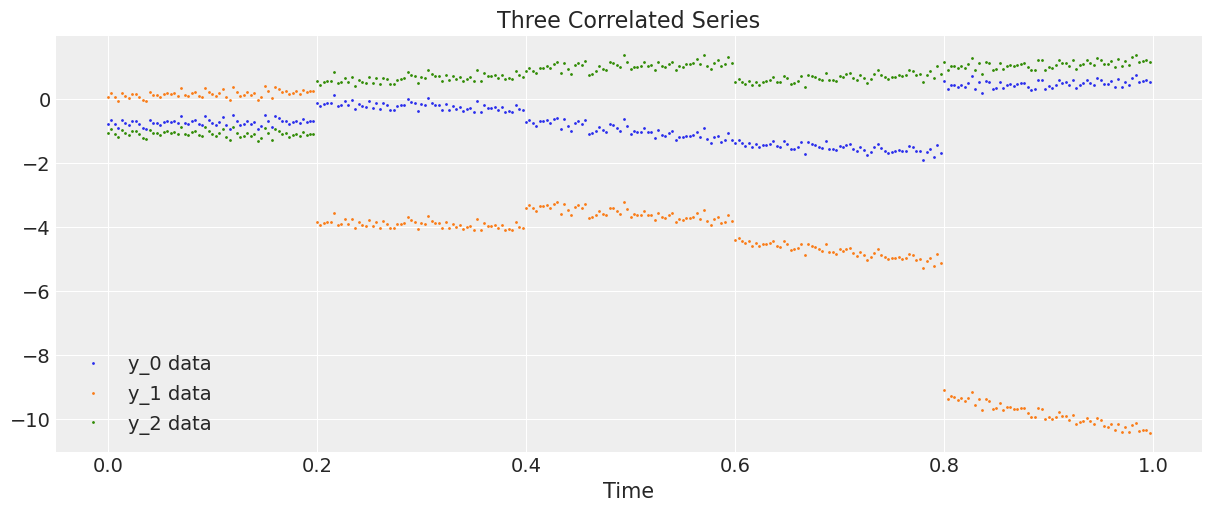

In [3]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
D = 3  # Dimension of random walks
N = 300  # Number of steps
sections = 5  # Number of sections
period = N / sections  # Number steps in each section

Sigma_alpha = rng.standard_normal((D, D))
Sigma_alpha = Sigma_alpha.T.dot(Sigma_alpha)  # Construct covariance matrix for alpha
L_alpha = cholesky(Sigma_alpha, lower=True)  # Obtain its Cholesky decomposition

Sigma_beta = rng.standard_normal((D, D))
Sigma_beta = Sigma_beta.T.dot(Sigma_beta)  # Construct covariance matrix for beta
L_beta = cholesky(Sigma_beta, lower=True)  # Obtain its Cholesky decomposition

# Gaussian random walks:
alpha = np.cumsum(L_alpha.dot(rng.standard_normal((D, sections))), axis=1).T
beta = np.cumsum(L_beta.dot(rng.standard_normal((D, sections))), axis=1).T
t = np.arange(N)[:, None] / N
alpha = np.repeat(alpha, period, axis=0)
beta = np.repeat(beta, period, axis=0)
# Correlated series
sigma = 0.1
y = alpha + beta * t + sigma * rng.standard_normal((N, 1))

# Plot the correlated series
plt.figure(figsize=(12, 5))
plt.plot(t, y, ".", markersize=2, label=("y_0 data", "y_1 data", "y_2 data"))
plt.title("Three Correlated Series")
plt.xlabel("Time")
plt.legend()
plt.show();

In [7]:
smoke_test = False
if smoke_test:
    df = df[df["ticker"] == "AAPL"]

df = df.pivot(index="date", columns="ticker", values="close")
df.head()

ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,43.559391,26.827240,43.078159,NaN,33.307190,27.224224,101.952751,103.480003,61.632336,35.965252,...,109.391174,21.795935,79.106964,31.314531,61.824543,44.791424,54.201454,93.761566,86.250000,50.134121
2017-01-04,44.130947,26.797222,43.685558,NaN,33.571598,27.417574,102.197891,104.139999,61.504833,35.902962,...,110.740364,21.989775,81.657669,31.453291,61.144352,45.459011,54.398685,94.623596,87.029999,50.620594
2017-01-05,43.606236,26.933493,44.016872,NaN,33.861607,27.138645,100.665894,105.910004,60.620850,35.638210,...,111.805496,22.219507,82.706886,31.453291,60.232868,45.044033,54.578751,95.231575,84.750000,50.452198
2017-01-06,44.964848,27.233753,44.030682,NaN,34.782772,27.408066,101.812698,108.300003,60.858856,34.820648,...,112.533356,22.147715,83.602333,31.545805,60.198853,44.728275,55.239014,95.240646,85.959999,50.611240
2017-01-09,45.105381,27.483202,44.320580,NaN,34.748661,27.011858,100.674614,108.570000,61.147835,34.844013,...,111.849892,22.233864,83.891777,31.067829,59.205746,44.538822,55.393360,97.091736,85.970001,50.470909


In [ ]:
df.dropna(inplace=True, how='all', axis=1)
df.head()